# Convolutional Neural Networks

## Project: Chest X-Ray Classification (Pneumonia vs Normal) 

---

### Instructions
For better understanding in this notebook some template code is already provided, and you will need to implement some additional functionalities to successfully complete this project.

> **Note for Implementation:** Sections that have **'IMPLEMENTATION'** heading, indicates that the following block needs implementations. Instructions details are provided for each implementation block and `To-DO` statments are also provided in the code cell. Before Starting to implement the functionality please read the instrcutions carefully and Pleaase do not modify or remove the template code!

---
### Project Description 

In this notebook, you will be implememnting a Convolutional Neural Network (CNN) model. You will go through different stages of data pre-processing and you will explore different methods by which we can implement a CNN model. 

The notebook is divided into following parts:

* Section 1: Import Dataset
* Section 2: Data Analysis & Pre-processing
* Section 3: Data Augumentation
* Section 4: Develop a CNN to Classify Chest X-Ray (from Scratch)
* Section 5: Develop a CNN to Classify Chest X-Ray (using Transfer Learning)
* Section 6: Comparison of CNN Models
* Section 7: Testing the best CNN Model

---
## Section 1: Import Dataset

### Chest X-Ray Dataset

For this project, we will be using [Chest X-Ray Images Dataset](https://www.kaggle.com/competitions/bst-261-pneumonia-chest-x-ray-classification/data), which you can find on the Kaggle competition set up for the course. This dataset consists of `5,863` X-Ray images and provides two classes of images (Normal and Pneumonia).

In the cells below, first we have imported the important libraries that will be useful throughout the notebook, we also have some constant variables like `DATASET_PATH, and IMG_CLASSES`. 

We also have a function `load_sample_imgs` which is used to load a sample training data, by which we can visualize the sample images for each class.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

Get data from Kaggle.

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c bst-261-pneumonia-chest-x-ray-classification

In [ ]:
! mkdir chest_xray

In [ ]:
! unzip bst-261-pneumonia-chest-x-ray-classification.zip -d chest_xray

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloaded Dataset Path (in google drive)
DATASET_PATH = "./chest_xray"
IMG_CLASSES = ['NORMAL', 'PNEUMONIA']

def load_sample_imgs(path):
    imgs = []
    for cls in IMG_CLASSES:
        dir_path = os.path.join(path, cls)
        img_name = os.listdir(dir_path)[0]
        img = cv2.imread(os.path.join(dir_path, img_name))
        cls_index = IMG_CLASSES.index(cls)
        imgs.append([img, cls_index])
    
    return imgs

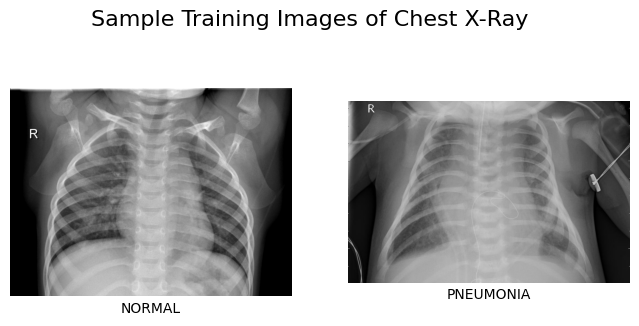

In [ ]:
sample_imgs = load_sample_imgs(os.path.join(DATASET_PATH, 'train'))
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

plt.suptitle('Sample Training Images of Chest X-Ray', fontsize=16, y=0.95)

for index in range(2):
    img, cls_index = sample_imgs[index]
    ax[index].imshow(img)
    ax[index].set_xticks([])             
    ax[index].set_yticks([])
    ax[index].set_xlabel(IMG_CLASSES[cls_index])
    ax[index].spines['top'].set_visible(False)
    ax[index].spines['right'].set_visible(False)        
    ax[index].spines['left'].set_visible(False)                
    ax[index].spines['bottom'].set_visible(False)                

plt.show()

In the figure above, we can see the visualization of sample training images for each class.

> **Note:** While loading the sample image data, we have loaded the data in format [image, cls_index]. This is one of the many approaches by which we can load the complete dataset in a structured manner.

### IMPLEMENTATION

While visualizing the sample images, we can see that both images are not of same size, it means in the dataset all the images are of not same size. In the cell below you can see a constant variable **IMG_SIZE**, this varaible will be used throughout the notebook and will represent the size of images in the dataset. **Do a research and choose an appropriate Image Size for the images.**

Now we will load the whole dataset. We know that the dataset is divided into three different subsets: `Training, Validation and Testing`. **So in the code cell below you will need to complete the implementation of the function which will be used to load the dataset for given path, and while loading the dataset resize the images according to the Image size that you have selected**. 

> **Note:** Use the same data loading structure that have been used while loading the sample data.

In [ ]:
# Visulize imaging attribute distribution

In [ ]:
DPATH = "/content/drive/MyDrive/chest_xray/train/NORMAL"
height = []
width = []
image_list = os.listdir(DPATH)

for img_name in image_list:
    img_path = os.path.join(DPATH, img_name)
    img = cv2.imread(img_path)

    if img is not None:
        height.append(img.shape[0])
        width.append(img.shape[1])


In [ ]:
DPATH = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"
heights = []
widths = []
image_list = os.listdir(DPATH)

for img_name in image_list:
    img_path = os.path.join(DPATH, img_name)
    img = cv2.imread(img_path)

    if img is not None:
        heights.append(img.shape[0])
        widths.append(img.shape[1])

In [ ]:
plt.hist(height, bins=20, color='blue', edgecolor='black')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution')
plt.show()

In [ ]:
plt.hist(width, bins=20, color='blue', edgecolor='black')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Width Distribution')
plt.show()

In [ ]:
plt.hist(heights, bins=20, color='blue', edgecolor='black')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution')
plt.show()

In [ ]:
heights_np = np.array(height)

mean = np.mean(heights_np)
median = np.median(heights_np)
std_dev = np.std(heights_np)
minimum = np.min(heights_np)
maximum = np.max(heights_np)
q1 = np.percentile(heights_np, 25)
q3 = np.percentile(heights_np, 75)

print("Mean height:", mean)
print("Median height:", median)
print("Standard deviation:", std_dev)
print("Minimum height:", minimum)
print("Maximum height:", maximum)
print("1st quartile (Q1):", q1)
print("3rd quartile (Q3):", q3)

In [ ]:
heights_np = np.array(width)

mean = np.mean(heights_np)
median = np.median(heights_np)
std_dev = np.std(heights_np)
minimum = np.min(heights_np)
maximum = np.max(heights_np)
q1 = np.percentile(heights_np, 25)
q3 = np.percentile(heights_np, 75)

print("Mean height:", mean)
print("Median height:", median)
print("Standard deviation:", std_dev)
print("Minimum height:", minimum)
print("Maximum height:", maximum)
print("1st quartile (Q1):", q1)
print("3rd quartile (Q3):", q3)

In [ ]:
heights_np = np.array(heights)

mean = np.mean(heights_np)
median = np.median(heights_np)
std_dev = np.std(heights_np)
minimum = np.min(heights_np)
maximum = np.max(heights_np)
q1 = np.percentile(heights_np, 25)
q3 = np.percentile(heights_np, 75)

print("Mean height:", mean)
print("Median height:", median)
print("Standard deviation:", std_dev)
print("Minimum height:", minimum)
print("Maximum height:", maximum)
print("1st quartile (Q1):", q1)
print("3rd quartile (Q3):", q3)

In [ ]:
heights_np = np.array(widths)

mean = np.mean(heights_np)
median = np.median(heights_np)
std_dev = np.std(heights_np)
minimum = np.min(heights_np)
maximum = np.max(heights_np)
q1 = np.percentile(heights_np, 25)
q3 = np.percentile(heights_np, 75)

print("Mean height:", mean)
print("Median height:", median)
print("Standard deviation:", std_dev)
print("Minimum height:", minimum)
print("Maximum height:", maximum)
print("1st quartile (Q1):", q1)
print("3rd quartile (Q3):", q3)

In [ ]:
##### IMPORTANT ######
# We got our final predication using 400 image size
# Limited by RAM, we have to use 224 image size here to run all model without system crush to show comparision plot
######################
img_size = 224
def load_data(data_dir):
    data = [] 
    for label in IMG_CLASSES: 
        path = os.path.join(data_dir, label)
        class_num = IMG_CLASSES.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Now after developing the data loading function, we will read the `Training` and `Validation` datasets. For now we will not going to load the `Testing` dataset because it will be used in the end to test the CNN models.

In [ ]:
train_data = load_data(os.path.join(DATASET_PATH, 'train'))
valid_data = load_data(os.path.join(DATASET_PATH, 'val'))

# print number of images in each dataset
print(f'There are {len(train_data)} Training Images.')
print(f'There are {len(valid_data)} Validation Images.')

We can see that we don't have a good amount of data for validation set, so now we need to combine both datasets, then split into training and testing sets. 


### IMPLEMENTATION
**In the cell below, first combine both sets, then split into training and validation sets. (80% for Training, 20% for Validation)**

In [ ]:
from sklearn.model_selection import train_test_split
combined_data = np.concatenate((train_data, valid_data), axis=0)
train_data, valid_data = train_test_split(combined_data, test_size=0.2, random_state=42)

# print number of images in each dataset
print(f'There are {len(train_data)} Training Images.')
print(f'There are {len(valid_data)} Validation Images.')

---
## Section 2: Data Pre-processing

Before starting to train the Deep Learning model we need to setup the dataset for best possible results. In our case as we are working with images the first thing to note is the size of all the images in the dataset and then we can move forward with all other techniques.

In our case as we have already setup the constant value for the size of all the images in the dataset so we don't need to worry about the size of the images in the dataset. Now we have multiple other steps that we need to take, first we will going to split the features and labels from the dataset that we have prepared early.

### Implementation
In the function below provide the code to split the features and labels into their seperate lists and then return the numpy arrays for each one of them.

Now as the function is ready to be used, so we will going to use the function to split features and labels from the dataset. First we will going to call the function for training dataset and then for validation dataset.

In [ ]:
### We didn't use function but use this way to achieve same goal
X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])

X_valid = np.array([x[0] for x in valid_data])
y_valid = np.array([x[1] for x in valid_data])

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{number_of_samples}, \text{image_height}, \text{image_width}, \text{channels}),
$$

where `number_of_samples` corresponds to the total number of images (or samples), and `image_height`, `image_width`, and `channels` correspond to the each image height, width, and channels.

By the running the cell below, we can check the tensor size of our training and validation data. First we will going to check the size of features and then we will move with labels/classes. 

In [ ]:
print(f'Training Features Tensor Shape: {x_train.shape}')
print(f'Validation Features Tensor Shape: {x_valid.shape}')
print('\n')
print(f'Training Labels Tensor Shape: {y_train.shape}')
print(f'Validation Labels Tensor Shape: {y_valid.shape}')

### OVERSAMPLING
After a lot of exploration and comparision, we found the imbalanced dataset problem and our models perform better in oversampling data. Thus, we added this part to add 2000 data by data augmentation to minority class to get around 3000:3000 balanced data.

In [ ]:
import numpy as np
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

# Identify the minority class
class_counts = Counter(y_train)
minority_class = min(class_counts, key=class_counts.get)

# Separate the images of the minority class
X_train_minority = X_train[y_train == minority_class]

In [ ]:
# Define the data augmentation parameters
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=[0.9, 1.1],
                     horizontal_flip=False, ###############
                     vertical_flip=False,
                     fill_mode='reflect',
                     data_format='channels_last')

# Create the ImageDataGenerator
image_datagen = ImageDataGenerator(**data_gen_args)

# Define the number of new samples you want to generate for the minority class
num_new_samples = 2000
augmented_images = []
augmented_labels = []

# Generate new samples using the ImageDataGenerator
for _ in range(num_new_samples):
    index = np.random.randint(0, len(X_train_minority))
    img = X_train_minority[index]
    img_augmented = image_datagen.random_transform(img)
    augmented_images.append(img_augmented)
    augmented_labels.append(minority_class)

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original and augmented data
X_train_balanced = np.concatenate((X_train, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train, augmented_labels), axis=0)

In [ ]:
X_train = X_train_balanced
y_train = y_train_balanced

### IMPLEMENTATION
For training and validation labels, we can see that we have tensors of shape `(200,)` and `(16,)`, which means we have a 1-D tensor. This is a binary dataset, which means we just have 2 classes in the dataset. For the better performance of the model we can use `One-Hot-Encoding` technique to One Hot Encode the labels, this is not a necessary step while working with Binary Classification data, but this is a cruicial step for Multi-Class Classification and that is why we also need to learn this step.

In the cell below you can implement the functionality to One-Hot Encode the labels of the dataset.

In [ ]:
# Convert labels to sequential integers
# Some models need this part to work
'''
unique_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_valid = np.array([label_map[label] for label in y_valid])
'''

In [ ]:
from keras.utils import to_categorical

# One-hot encoding for training and validation labels
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [ ]:
# rescale validation data
X_valid = X_valid.astype("float64")/255.0

Now after implementing the `One-Hot Encoding` functionality we can again check the shape of the labels.

In [ ]:
print(f'Training Labels Tensor Shape: {y_train.shape}')
print(f'Validation Labels Tensor Shape: {y_valid.shape}')

Now we have setup the features and labels of the dataset, let's explore the data a bit more and let us visualize the channels of the images. We know that the data is in `3 Channels` which means that the images in the dataset are having `Reg, Blue and Green` color channel which is also known as `RGB`. By running the cell below, we can visualize the image in each color channel. 

In [ ]:
image = x_train[0]

# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(image[:, : , 0]) #Red
ax3.imshow(image[:, : , 1]) #Green
ax4.imshow(image[:, : , 2]) #Blue
f.suptitle('Different Channels of Chest X-Ray Image')

In [ ]:
print(f'Training Features Tensor Shape: {X_train.shape}')
print(f'Validation Features Tensor Shape: {X_valid.shape}')
print('\n')
print(f'Training Labels Tensor Shape: {y_train.shape}')
print(f'Validation Labels Tensor Shape: {y_valid.shape}')

In [ ]:
# save data cause to avoid crush
'''
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_valid.npy', X_valid)
np.save('y_valid.npy', y_valid)
'''

In [ ]:
# start here to load data if colab crush
'''
import numpy as np
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_valid = np.load('X_valid.npy')
y_valid = np.load('y_valid.npy')
'''

---
## Section 3: Data Augumentation

Data augmentation is a technique used in machine learning to artificially increase the size and diversity of a dataset by generating new data from existing data. Data augmentation provides improvement in the performance of machine learning models by exposing them to a wider range of variations in the data. Data augmentation is commonly used in computer vision applications such as image classification, object detection, and segmentation. 

For data augumentation we can make use of multiple techniques like Flipping, Rotation, Scaling, Cropping, Translation, Adding Noise to the image, etc. 

### IMPLEMENTATION
For Data Augumentation we will be using `ImageDataGenerator` function provided by `keras` library. In the cell below you have boilerplate code for the initialization of ImageDataGenerator object, while initializing the object, we need to pass in arguments which Augumentation techniques we need to use. 

**In the code below, we already have two arguments (Augumentation Techniques), you need to provide at least 2 more arguments to Augument the data, you can provide more as you want.** 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# This combination is what we applied to get best result in VGG_16
# To be consistent, will use it for all models' data augmentation for comparison
datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1 ,brightness_range=(0.95,1.05), zoom_range=0.1)

Now after initializing the data augumentation object, we need to use this object to visualize the dataset. 

In the cell below, we will use one single sample image and generate the augumented images. The generator object will augument the sample image and generate different samples of the images by the help of the techniques which we have provided. 

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

temp_batch = datagen.flow(x_train[:1], batch_size=1)

index = 0
for i in range(4):
    for j in range(4):
        img = next(temp_batch)[0]
        axes[i, j].imshow(img[:,:,0])
        index = index +1

---
## Section 4: Develop a CNN to Classify Chest X-Ray (from Scratch)

We have completed the Data pre-processing part, now it is the time to start developing the Convolutional Neural Network model. For this project we will be going to work with keras and Tensorflow library to develop and train the CNN model. CNN models have multiple layers that we can use, some of the standard layers that we need to use while working with CNN models are `Convolutinal Layer, Pooling Layer, Dropout Layer, Flatten Layer and Dense Layer`.

### IMPLEMENTATION
Now in the cell below we will going to define our model architecture. You have been given a boiler plate code with 1 Convolutional Layer and Output Layer of the model. 

**By using the boilerplate code develop a Convolutional Model architecutre. You need to use Conv2D, Pooling, Dropout and Dense Layers, etc. Please don't change anything in the boilerplate code.**

In [ ]:
img_size=224
# deeper structure with fewer parameter
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

# Building CNN model
# Initializing the Model
cnn_model = Sequential()

# Conv Layer
cnn_model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=(img_size, img_size, 3)))
# Pooling layer
cnn_model.add(MaxPooling2D(pool_size=2))
# Dropout layer
cnn_model.add(Dropout(0.1))

cnn_model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))


# Flatten layer
cnn_model.add(Flatten())

# Dense layers
cnn_model.add(Dense(128, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.5))

# Output Layer of the Model
cnn_model.add(Dense(2, activation="softmax"))

# Model Summary
cnn_model.summary()

The output of the above cell shows the summary of the CNN model. With the help of the model summary, we can see the trainable parameters, the complexity of the model, we can also check the output data shape for each layer. This is a good way to check the complexity of the model. 

Now we need to compile the model. While compiling the model we need to provide `loss function`, `optimizer`, and `metrics` which will be used during the training process of the Deep Learning model. There are many different choices of loss functions and optimizers which are avilable and we need to choose the best for our use case. 

### IMPLEMENTATION
In the cell below, **you need to provide the LOSS function and Optimization Function for the CNN Model**.

- [Available Loss Functions](https://keras.io/api/losses/probabilistic_losses/)
- [Available Optimization Functions](https://keras.io/api/optimizers/)

In [ ]:
# best optimizer after tuning and tried different optimizer for this model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=4e-5)

In [ ]:
cnn_model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

### IMPLEMENTATION

Now in the cell below we will be going to train our Convolutional Neural Network Model. For the training of the CNN model, **you need to provide a `Batch size` and `Number of Epochs`**. And after that you can run this cell to start the training process of the model.

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1, save_freq='epoch')

In [ ]:
Epochs = 20
BATCH_SIZE = 20

cnn_model_history = cnn_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),\
                                validation_data=(x_valid, y_valid), epochs=Epochs,\
                                verbose=1, shuffle=True, callbacks=[checkpoint])

#### Evaluating the Trained Model
After training the Model, it is a good paractice to evaluate the model on Training Dataset to get the final Training Accuracy and Loss of the Model. By running the cell below you will be able to find out the training accuracy and loss of the CNN model. 

In [ ]:
# load best model weights
cnn_model.load_weights("best_cnn_model.h5")
# evaluate the model
training_score = cnn_model.evaluate(X_train, y_train)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3),"%")
print("Training Loss:", training_score[0])

In [ ]:
validation_score = cnn_model.evaluate(X_valid, y_valid)
print("\nvalidation Accuracy:", round((validation_score[1] * 100), 3),"%")
print("validation Loss:", validation_score[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = cnn_model.predict(X_train)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_train, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)

---
## Section 5: Develop a CNN to Classify Chest X-Ray (using Transfer Learning)

**For better warp up. We showed by models. One part included both model information, complie, and implementation, and evaluation.**

Now in this section we will be using pre-trained CNN model and train it using Transfer Learning Techniques. Transfer learning is a powerfull technique by which we can make use of complex and large pre-trained models and improve those models on our datasets. We have many different pre-trained CNN models available, you can access the list of all pre-trainned models in Keras Document, [link to pre-trained models](https://keras.io/api/applications/). 

There are different types of Transfer Learning techniques available, for this project we will be using `Fine Tuning` approach. Fine-tuning in transfer learning is a technique which is used to adapt a pre-trained model to a new dataset. This involves taking a pre-trained model that has been trained on a large dataset, and then improving it for a different dataset. The idea is that the model has already learned some general features and patterns from the original dataset, and these can be useful for the new dataset.

The First step to implement the Fine Tuning approach is to initialize a pre-trained model. **From the list of all available pre-trained models, choose a model according to your choice and initialize it in the cell given below**.

Now in the second step of Fine Tuning, we need to add some `Dense` layers to the model. As you can see in the cell above, we have explicitly turned off the training of all the layers inside the pre-trainned model because we don't want the pre-trained model to be trained we just want to add some layers at the end of the model and then we will going to train those layers.

In the cell below, you have given a boilerplate code, the loaded pre-trained model has been attached to the CNN architecture and also the output layer of the model is initialized. **You need to add some more Dense, Dropout Layers in the CNN model architecture**.

In the Model Summary we can see that, the total number of parameters are much more higher than the trainable parameters. This is the best part of fine-tuning a CNN model, because we will use a pre-trained model and adapt it on our dataset even if we have less resources to train a large complex model.

Now we need to compile the model. While compiling the model we need to provide `loss function`, `optimizer`, and `metrics` which will be used during the training process of the Deep Learning model. There are many different choices of loss functions and optimizers which are avilable and we need to choose the best for our use case. 

In the cell below, **you need to provide the LOSS function and Optimization Function for the CNN Model**.

- [Available Loss Functions](https://keras.io/api/losses/probabilistic_losses/)
- [Available Optimization Functions](https://keras.io/api/optimizers/)


Now in the cell below we will be going to train the Convolutional Neural Network Model. As we have trained the CNN model previously, it will going to be the same steps. **Provide the code for training the CNN Model, and train the model on same number of Epochs as the previous CNN model**.

#### Evaluating the Trained Model
After training the Model, it is a good paractice to evaluate the model on Training Dataset to get the final Training Accuracy and Loss of the Model. By running the cell below you will be able to find out the training accuracy and loss of the CNN model which is trained by transfer learning. 

### ResNet50
ResNet50

In [ ]:
import tensorflow
from tensorflow import keras

from tensorflow.keras.applications import ResNet50
res_pretrained_model = ResNet50(include_top = False, weights ='imagenet', input_shape = (224,224,3))
for layer in res_pretrained_model.layers:
        layer.trainable=False

### InceptionV3
InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
inc_pretrained_model = InceptionV3(include_top = False, weights ='imagenet', input_shape = (224,224,3))
for layer in inc_pretrained_model.layers:
        layer.trainable=False

In [ ]:
#INCEPTION
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
inc_transfer_model = Sequential()     
inc_transfer_model.add(inc_pretrained_model)

# Hint: Add a pooling layer to reduce the input size to dense layer.
inc_transfer_model.add(tf.keras.layers.GlobalAveragePooling2D())

#TODO: Add some Dense, Dropout Layers
inc_transfer_model.add(tf.keras.layers.Dense(64, activation='relu'))
inc_transfer_model.add(tf.keras.layers.Dropout(0.5))
inc_transfer_model.add(tf.keras.layers.Dense(64, activation='relu'))
inc_transfer_model.add(tf.keras.layers.Dropout(0.4))
inc_transfer_model.add(tf.keras.layers.Dense(32, activation='relu'))
inc_transfer_model.add(tf.keras.layers.Dropout(0.3))

# Hint: Keep your size of Dense layer small (i.e. number of units in the dense layers. You may find colab crashing if you have too many params.)
# Output Layer of the Model
inc_transfer_model.add(Dense(2, activation='softmax'))
inc_transfer_model.summary()

In [ ]:
inc_transfer_model.compile(optimizer=SGD(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("best_inc_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1, save_freq='epoch')
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
#TODO: You need to provide the Batch Size, Number of Epochs will be the same as before
BATCH_SIZE = 20

inc_transfer_model_history = inc_transfer_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),\
                                            validation_data=(X_valid, y_valid), epochs=Epochs,\
                                            verbose=1, shuffle=True, callbacks=[checkpoint, early_stop])

### DenseNet201
DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201
den_pretrained_model = DenseNet201(include_top = False, weights ='imagenet',  input_shape = (224,224,3))
for layer in den_pretrained_model.layers:
        layer.trainable=False

In [ ]:
# DenseNet
# We thought we did chexnet, but actually it is not reproducible
# chexnet is based on densenet
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
base_model = densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation='softmax')(x)

# Create the final model
chexnet_model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
densenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("best_densenet_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only = True, mode="max", verbose=1)

In [ ]:
densenet_model_history = chexnet_model.fit(datagen.flow(X_train, y_train, batch_size=20),
                                          validation_data=(X_valid, y_valid), epochs=10,
                                          verbose=1, shuffle=True, callbacks=[checkpoint])


In [ ]:
densenet_model.load_weights("best_densenet_model.h5")

In [ ]:
training_score = densenet_model.evaluate(X_train.astype("float32")/255.0, y_train)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3), "%")
print("Training Loss:", training_score[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = densenet_model.predict(X_train.astype("float32")/255.0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_train, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)


### EfficientNetV2S
EfficientNetV2S

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
eff_pretrained_model = EfficientNetV2S(include_top = False, weights ='imagenet',  input_shape = (224,224,3))

for i, layer in enumerate(eff_pretrained_model.layers):
    if i < len(eff_pretrained_model.layers) - 2:
        layer.trainable = False
    else:
        layer.trainable = True
#EFFICIENTNET
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
eff_transfer_model = Sequential()     
eff_transfer_model.add(eff_pretrained_model)
eff_transfer_model.add(Flatten())
# Hint: Add a pooling layer to reduce the input size to dense layer.

#TODO: Add some Dense, Dropout Layers
eff_transfer_model.add(Dense(128, activation='relu'))
eff_transfer_model.add(Dropout(0.3))
eff_transfer_model.add(Dense(16, activation='relu'))
eff_transfer_model.add(Dropout(0.3))
# Hint: Keep your size of Dense layer small (i.e. number of units in the dense layers. You may find colab crashing if you have too many params.)
# Output Layer of the Model
eff_transfer_model.add(Dense(2, activation='softmax'))
eff_transfer_model.summary()

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
eff_transfer_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_eff_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1, save_freq='epoch')

In [ ]:
#TODO: You need to provide the Batch Size, Number of Epochs will be the same as before
BATCH_SIZE = 20

eff_transfer_model_history = eff_transfer_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),\
                                            validation_data=(X_valid, y_valid), epochs=20,\
                                            verbose=1, shuffle=True, callbacks=[checkpoint])

In [ ]:
eff_transfer_model.load_weights("best_eff_model.h5")
training_score = eff_transfer_model.evaluate(X_train, y_train)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3), "%")
print("Training Loss:", training_score[0])

In [ ]:
training_score = eff_transfer_model.evaluate(X_valid, y_valid)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3), "%")
print("Training Loss:", training_score[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = eff_transfer_model.predict(X_train)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_train, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)

### VGG16
VGG16

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import VGG16

# Load VGG16 base model without the top classification layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze all layers except for the last 4
for i, layer in enumerate(vgg_model.layers):
    if i < len(vgg_model.layers) - 3:
        layer.trainable = False
    else:
        layer.trainable = True

# Add custom layers
x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(512, activation='relu')(x)  # Add a fully connected layer with 512 units
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting

predictions = Dense(2, activation='softmax')(x)  # Add the final classification layer

# Create the final model
vgg_transfer_model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model
vgg_transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_transfer_model.summary()


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_VGG_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1, save_freq='epoch')

In [ ]:
#TODO: You need to provide the Batch Size, Number of Epochs will be the same as before
BATCH_SIZE = 20

vgg_transfer_model_history = vgg_transfer_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),\
                                            validation_data=(X_valid, y_valid), epochs=20,\
                                            verbose=1, shuffle=True, callbacks=[checkpoint])

In [ ]:
vgg_transfer_model.load_weights("best_model.h5")

In [ ]:
# save weights
import os

# Replace 'My_Models' with the name of the folder where you want to save the weights
folder_path = "/content/drive/My Drive/My_Models2"

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# Replace 'best_model_weights.h5' with the desired name for your weights file
# Replace 'best_model_weights.h5' with the desired name for your weights file
weights_file_path = os.path.join(folder_path, 'best_VGG_mode.h5')

# Save the weights
vgg_transfer_model.save_weights(weights_file_path)

In [ ]:
#vgg_transfer_model.load_weights("best_model_epoch_06.h5")
training_score = vgg_transfer_model.evaluate(X_train.astype("float32")/255.0, y_train)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3), "%")
print("Training Loss:", training_score[0])

In [ ]:
training_score = vgg_transfer_model.evaluate(X_valid, y_valid)
print("\nTraining Accuracy:", round((training_score[1] * 100), 3), "%")
print("Training Loss:", training_score[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = vgg_transfer_model.predict(X_train.astype("float32")/255.0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_train, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = vgg_transfer_model.predict(X_train.astype("float32")/255.0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_train, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

# Print confusion matrix with row and column names
print("Confusion Matrix:")
print("                   Predicted Class")
print("                   ---------------")
print("                       |  Normal  |  Pneumonia  |")
print("                   ---------------")
print("True Class | Normal.   | {:5d}    | {:5d} |".format(cm[0][0], cm[0][1]))
print("           | Pneumonia | {:5d}    | {:5d} |".format(cm[1][0], cm[1][1]))
print("                   ---------------")


In [ ]:
# Download predication table
img_size = 350
def load_data(data_dir):
    data = [] 
    path = data_dir
    for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, img])
            except Exception as e:
                print(e)
    return np.array(data)

test_data = load_data(os.path.join(DATASET_PATH, 'test'))

# print number of images in each dataset
print(f'There are {len(test_data)} Training Images.')

X_test = np.array([x[0] for x in test_data])
X_test = X_test.astype("float32")/255.0
y_test = np.array([x[1] for x in test_data])

print(f'Training Features Tensor Shape: {X_test.shape}')
print(f'Training Features Tensor Shape: {y_test.shape}')

y_test_prob = vgg_transfer_model.predict(X_test)
y_test_pred = np.argmax(y_test_prob, axis=1)

results_df = pd.DataFrame({"ID":y_test,"class": y_test_pred})
df = results_df
df['class'] = df['class'].map({0: 'NORMAL', 1: 'PNEUMONIA'})

df['ID_number'] = df['ID'].str.extract('(\d+)').astype(int)

df_sorted = df.sort_values(by='ID_number')
df_sorted.drop('ID_number', axis=1, inplace=True)

df_sorted.to_csv("predicted_labels.csv", index=False)

from google.colab import files

files.download("predicted_labels.csv")


In [ ]:
#TODO: Provide Loss and Optimizer functions
transfer_model.compile(optimizer=None, loss=None, metrics=['accuracy'])

In [ ]:
#TODO: You need to provide the Batch Size, Number of Epochs will be the same as before
BATCH_SIZE = None

transfer_model_history = transfer_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),\
                                            validation_data=(x_valid, y_valid), epochs=Epochs,\
                                            verbose=1, shuffle=True)

In [ ]:
transfer_model_score = transfer_model.evaluate(x_train, y_train)

print("\nTraining Accuracy:", round((transfer_model_score[1] * 100), 3),"%")
print("Training Loss:", transfer_model_score[0])

---
## Section 6: Comparison of CNN Models

### Visualizing Model Loss And Accuracy

We have successfully trained both CNN models and now it's time to compare the accuracy and loss of both models to know which one is the best one. While training the models, we can see that we have used **cnn_model_history variable** and **transfer_model_history variable**, these variable are used to store the accuracy and loss of the model for all Epochs. These variable holds the data in the form of python dictionary.

### IMPLEMENTATION
**By using the `cnn_model_history` and `transfer_model_history` variables and matplotlib library plot the Accuracy and Loss graphs of the models. You need to plot Accuracy and Loss graphs having Training and Validation data for both models.**

In [ ]:
#TODO: Plot the Accuracy Graph

In [ ]:
#TODO: Plot the Loss Graph

---
## Section 7: Testing the best CNN Model

Now in this last section of the Notebook, we will test the best CNN model.

#### IMPLEMENTATION
**Load the testing set in the cell below.**

In [ ]:
# TODO: Load the Testing Dataset
test_data = None

# print number of images in testing dataset
print(f'There are {len(test_data)} Testing Images.')

### IMPLEMENTATION
**Split the Features and Labels of the Testing Set.**

In [ ]:
# TODO: Split the Features and Labels of Testing Data
x_test, y_test = None

print(f'Testing Features Tensor Shape: {x_test.shape}')

We have loaded and setup the testing dataset, now it's time to use the best model and make the prediction for testing images.

In [ ]:
predictions = transfer_model.predict(x_test)
prediction_labels = np.argmax(predictions, axis=1)
# Save as csv. File saved in current directory.
np.savetxt("prediction_labels.csv", prediction_labels, delimiter=",")

### Confusion Matrix
A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the model compared to the actual outcomes. The matrix is usually presented as a square table, with the rows representing the actual class labels and the columns representing the predicted class labels. The confusion matrix provides several useful metrics for evaluating the performance of a classification model, such as accuracy, precision, recall, and F1 score. 

### IMPLEMENTATION
We have original labels and predicted labels, now you need to use **scikit-learn** and **matplotlib** lilbrary to plot the confusion matrix.

Not required since you won't have access to true labels.

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Not Required

### Classification Report

A classification report is a summary of the key performance metrics for a classification model. The classification report includes several important metrics, including precision, recall, F1 score, and support. These metrics provide information about the model's ability to correctly identify positive and negative instances, as well as the balance between precision and recall.

Please run the cell below to generate the classification report for the Best Performing CNN Model.

In [ ]:
# print(classification_report(y_test, prediction_labels))
# Not Required

---
## Conclusion

In the Notebook, we have learned how we can develop Convolutional Neural Network Models. We have learned how we can develop our own CNN architectures and how we can make use of Transfer Learning Techniques. We have gone through the data preperation part, model development part and finally we have evaluated and tested the CNN Models. 